## Selenium과 Beautiful Soup을 이용한 데이터 획득 준비 작업

In [1]:
import pandas as pd
import numpy as np

import platform
import matplotlib.pyplot as plt

%matplotlib inline

from matplotlib import rc

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    
plt.rcParams['axes.unicode_minus'] = False

In [2]:
from selenium import webdriver
import time

In [3]:
driver = webdriver.Chrome('../4/chromedriver')
driver.get("http://info.nec.go.kr/main/showDocument.xhtml?electionId=0000000000&topMenuId=VC&secondMenuId=VCCP09")

In [4]:
driver.find_element_by_id("electionType1").click()

In [5]:
driver.find_element_by_id("electionName").send_keys("제19대")

In [9]:
driver.find_element_by_id("electionCode").send_keys("대통령선거")

In [10]:
sido_list_raw = driver.find_element_by_xpath("""//*[@id="cityCode"]""")
sido_list = sido_list_raw.find_elements_by_tag_name('option')
sido_names_values = [option.text for option in sido_list]
sido_names_values = sido_names_values[2:]
sido_names_values

['서울특별시',
 '부산광역시',
 '대구광역시',
 '인천광역시',
 '광주광역시',
 '대전광역시',
 '울산광역시',
 '세종특별자치시',
 '경기도',
 '강원도',
 '충청북도',
 '충청남도',
 '전라북도',
 '전라남도',
 '경상북도',
 '경상남도',
 '제주특별자치도']

In [11]:
element = driver.find_element_by_id('cityCode')
element.send_keys(sido_names_values[0])

## 19대 대선 개표 결과 데이터 획득하기

In [46]:
import re

def get_num(tmp):
    return float(re.split('\(', str(tmp))[0].replace(',',''))

In [47]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

wait = WebDriverWait(driver, 10)

def move_sido(name):
    element = driver.find_element_by_id("cityCode")
    element.send_keys(name)
    make_xpath = """//*[@id="searchBtn"]"""
    wait.until(EC.element_to_be_clickable((By.XPATH,make_xpath)))
    driver.find_element_by_xpath(make_xpath).click()

In [48]:
def append_data(df, sido_name, data):
    for each in df[0].values[1:]:
        data['광역시도'].append(sido_name)
        data['시군'].append(each[0])
        data['pop'].append(get_num(each[2]))
        data['moon'].append(get_num(each[3]))
        data['hong'].append(get_num(each[4]))
        data['ahn'].append(get_num(each[5]))

In [49]:
election_result_raw = {'광역시도' : [],
                       '시군' : [],
                       'pop' : [],
                       'moon' : [],
                       'hong' : [],    
                       'ahn' : [] }

In [50]:
from bs4 import BeautifulSoup

for each_sido in sido_names_values:
    move_sido(each_sido)
    
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    table = soup.find('table')
    
    df = pd.read_html(str(table))
    
    append_data(df, each_sido, election_result_raw)

In [45]:
election_result = pd.DataFrame(election_result_raw, 
                               columns=['광역시도', '시군', 'pop', 'moon','hong','ahn'])
election_result

,광역시도,시군,pop,moon,hong,ahn
0,서울특별시,종로구,102566.0,42512.0,22325.0,22313.0
1,서울특별시,중구,82852.0,34062.0,17901.0,19372.0
2,서울특별시,용산구,148157.0,58081.0,35230.0,32109.0
3,서울특별시,성동구,203175.0,86686.0,40566.0,45674.0
4,서울특별시,광진구,240030.0,105512.0,46368.0,52824.0
5,서울특별시,동대문구,236092.0,98958.0,51631.0,53359.0
6,서울특별시,중랑구,265706.0,111450.0,56545.0,62778.0
7,서울특별시,성북구,295866.0,129263.0,57584.0,66518.0
8,서울특별시,강북구,210614.0,89645.0,42268.0,51669.0
9,서울특별시,도봉구,229233.0,94898.0,47461.0,55600.0


In [51]:
election_result.to_csv('./election_result.csv', encoding='utf-8', sep=',')

In [52]:
driver.close()

## 각 후보와 득표율과 지역 ID 정리하기

In [53]:
election_result = pd.read_csv('./election_result.csv', encoding='utf-8', index_col=0)

election_result.head()

,광역시도,시군,pop,moon,hong,ahn
0,서울특별시,종로구,102566.0,42512.0,22325.0,22313.0
1,서울특별시,중구,82852.0,34062.0,17901.0,19372.0
2,서울특별시,용산구,148157.0,58081.0,35230.0,32109.0
3,서울특별시,성동구,203175.0,86686.0,40566.0,45674.0
4,서울특별시,광진구,240030.0,105512.0,46368.0,52824.0


In [54]:
sido_candi = election_result['광역시도']
sido_candi = [name[:2] if name[:2] in ['서울', '부산', '대구', '광주', '인천', '대전', '울산'] 
              else '' for name in sido_candi]

In [55]:
def cut_char_sigu(name):
    return name if len(name) == 2 else name[:-1]

In [56]:
import re

In [57]:
sigun_candi = [''] * len(election_result)

for n in election_result.index:
    each = election_result['시군'][n]
    if each[:2] in ['수원', '성남', '안양', '안산', '고양','용인', '청주', '천안', '전주', '포항', '창원']:
        sigun_candi[n] = re.split('시', each)[0] + ' ' + cut_char_sigu(re.split('시', each)[1])
    else:
        sigun_candi[n] = cut_char_sigu(each)
sigun_candi

['종로',
 '중구',
 '용산',
 '성동',
 '광진',
 '동대문',
 '중랑',
 '성북',
 '강북',
 '도봉',
 '노원',
 '은평',
 '서대문',
 '마포',
 '양천',
 '강서',
 '구로',
 '금천',
 '영등포',
 '동작',
 '관악',
 '서초',
 '강남',
 '송파',
 '강동',
 '중구',
 '서구',
 '동구',
 '영도',
 '부산진',
 '동래',
 '남구',
 '북구',
 '해운대',
 '기장',
 '사하',
 '금정',
 '강서',
 '연제',
 '수영',
 '사상',
 '중구',
 '동구',
 '서구',
 '남구',
 '북구',
 '수성',
 '달서',
 '달성',
 '중구',
 '동구',
 '남구',
 '연수',
 '남동',
 '부평',
 '계양',
 '서구',
 '강화',
 '옹진',
 '동구',
 '서구',
 '남구',
 '북구',
 '광산',
 '동구',
 '중구',
 '서구',
 '유성',
 '대덕',
 '중구',
 '남구',
 '동구',
 '북구',
 '울주',
 '세종특별자치',
 '수원 장안',
 '수원 권선',
 '수원 팔달',
 '수원 영통',
 '성남 수정',
 '성남 중원',
 '성남 분당',
 '의정부',
 '안양 만안',
 '안양 동안',
 '부천',
 '광명',
 '평택',
 '양주',
 '동두천',
 '안산 상록',
 '안산 단원',
 '고양 덕양',
 '고양 일산동',
 '고양 일산서',
 '과천',
 '의왕',
 '구리',
 '남양주',
 '오산',
 '화성',
 '시흥',
 '군포',
 '하남',
 '파주',
 '여주',
 '이천',
 '용인 처인',
 '용인 수지',
 '용인 기흥',
 '안성',
 '김포',
 '광주',
 '포천',
 '연천',
 '양평',
 '가평',
 '춘천',
 '원주',
 '강릉',
 '동해',
 '삼척',
 '태백',
 '정선',
 '속초',
 '고성',
 '양양',
 '인제',
 '홍천',
 '횡성',
 '영월',
 '평창',
 '화천',
 '양구

In [59]:
ID_candi = [sido_candi[n] + ' ' + sigun_candi[n] for n in range(0, len(sigun_candi))]

ID_candi = [name[1:] if name[0] == ' ' else name for name in ID_candi]
ID_candi = [name[:2] if name[:2] == '세종' else name for name in ID_candi]

ID_candi

['서울 종로',
 '서울 중구',
 '서울 용산',
 '서울 성동',
 '서울 광진',
 '서울 동대문',
 '서울 중랑',
 '서울 성북',
 '서울 강북',
 '서울 도봉',
 '서울 노원',
 '서울 은평',
 '서울 서대문',
 '서울 마포',
 '서울 양천',
 '서울 강서',
 '서울 구로',
 '서울 금천',
 '서울 영등포',
 '서울 동작',
 '서울 관악',
 '서울 서초',
 '서울 강남',
 '서울 송파',
 '서울 강동',
 '부산 중구',
 '부산 서구',
 '부산 동구',
 '부산 영도',
 '부산 부산진',
 '부산 동래',
 '부산 남구',
 '부산 북구',
 '부산 해운대',
 '부산 기장',
 '부산 사하',
 '부산 금정',
 '부산 강서',
 '부산 연제',
 '부산 수영',
 '부산 사상',
 '대구 중구',
 '대구 동구',
 '대구 서구',
 '대구 남구',
 '대구 북구',
 '대구 수성',
 '대구 달서',
 '대구 달성',
 '인천 중구',
 '인천 동구',
 '인천 남구',
 '인천 연수',
 '인천 남동',
 '인천 부평',
 '인천 계양',
 '인천 서구',
 '인천 강화',
 '인천 옹진',
 '광주 동구',
 '광주 서구',
 '광주 남구',
 '광주 북구',
 '광주 광산',
 '대전 동구',
 '대전 중구',
 '대전 서구',
 '대전 유성',
 '대전 대덕',
 '울산 중구',
 '울산 남구',
 '울산 동구',
 '울산 북구',
 '울산 울주',
 '세종',
 '수원 장안',
 '수원 권선',
 '수원 팔달',
 '수원 영통',
 '성남 수정',
 '성남 중원',
 '성남 분당',
 '의정부',
 '안양 만안',
 '안양 동안',
 '부천',
 '광명',
 '평택',
 '양주',
 '동두천',
 '안산 상록',
 '안산 단원',
 '고양 덕양',
 '고양 일산동',
 '고양 일산서',
 '과천',
 '의왕',
 '구리',
 '남양주',
 '오산',
 '화성',
 '시흥',
 '군포',
 '하남'

In [60]:
election_result['ID'] = ID_candi

election_result.head()

,광역시도,시군,pop,moon,hong,ahn,ID
0,서울특별시,종로구,102566.0,42512.0,22325.0,22313.0,서울 종로
1,서울특별시,중구,82852.0,34062.0,17901.0,19372.0,서울 중구
2,서울특별시,용산구,148157.0,58081.0,35230.0,32109.0,서울 용산
3,서울특별시,성동구,203175.0,86686.0,40566.0,45674.0,서울 성동
4,서울특별시,광진구,240030.0,105512.0,46368.0,52824.0,서울 광진


In [61]:
election_result[['rate_moon', 'rate_hong', 'rate_ahn']] = election_result[['moon', 'hong', 'ahn']].div(election_result['pop'], axis=0)

election_result[['rate_moon', 'rate_hong', 'rate_ahn']] *= 100

election_result.head()

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
0,서울특별시,종로구,102566.0,42512.0,22325.0,22313.0,서울 종로,41.448433,21.766472,21.754773
1,서울특별시,중구,82852.0,34062.0,17901.0,19372.0,서울 중구,41.111862,21.605996,23.381451
2,서울특별시,용산구,148157.0,58081.0,35230.0,32109.0,서울 용산,39.202333,23.778829,21.672280
3,서울특별시,성동구,203175.0,86686.0,40566.0,45674.0,서울 성동,42.665682,19.966039,22.480128
4,서울특별시,광진구,240030.0,105512.0,46368.0,52824.0,서울 광진,43.957839,19.317585,22.007249


In [62]:
election_result.sort_values(['rate_moon'], ascending=False).head(10)

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
182,전라남도,순천시,181451.0,122595.0,4525.0,40429.0,순천,67.563695,2.493786,22.280946
166,전라북도,전주시덕진구,187921.0,125375.0,5183.0,40188.0,전주 덕진,66.716865,2.758074,21.385582
165,전라북도,전주시완산구,236383.0,157637.0,7003.0,50506.0,전주 완산,66.687114,2.962565,21.366173
175,전라북도,장수군,16079.0,10714.0,717.0,3353.0,장수,66.633497,4.459233,20.853287
184,전라남도,광양시,96384.0,63544.0,4100.0,20080.0,광양,65.927955,4.253818,20.833333
173,전라북도,진안군,18107.0,11918.0,819.0,3904.0,진안,65.819849,4.523113,21.560722
172,전라북도,완주군,62470.0,41057.0,2107.0,13897.0,완주,65.722747,3.372819,22.245878
168,전라북도,익산시,192208.0,123422.0,6470.0,45737.0,익산,64.212728,3.366145,23.795576
170,전라북도,남원시,55371.0,35539.0,1939.0,13854.0,남원,64.183417,3.501833,25.020317
63,광주광역시,광산구,248209.0,159119.0,3630.0,65402.0,광주 광산,64.106862,1.462477,26.349568


In [63]:
election_result.sort_values(['rate_hong'], ascending=False).head(10)

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
219,경상북도,군위군,17627.0,2251.0,11651.0,1939.0,군위,12.770182,66.097464,11.000170
220,경상북도,의성군,37855.0,5365.0,23790.0,4767.0,의성,14.172500,62.845067,12.592788
223,경상북도,영덕군,26125.0,3786.0,16314.0,3231.0,영덕,14.491866,62.445933,12.367464
247,경상남도,합천군,33021.0,7143.0,19699.0,3077.0,합천,21.631689,59.655976,9.318313
216,경상북도,고령군,22396.0,3754.0,13248.0,2600.0,고령,16.761922,59.153420,11.609216
213,경상북도,예천군,32124.0,5261.0,18863.0,4427.0,예천,16.377163,58.719338,13.780974
215,경상북도,청도군,30398.0,5323.0,17678.0,3654.0,청도,17.511020,58.155142,12.020528
221,경상북도,청송군,18418.0,3218.0,10669.0,2387.0,청송,17.472038,57.927028,12.960148
240,경상남도,창녕군,42878.0,10310.0,24464.0,3877.0,창녕,24.044965,57.054900,9.041933
212,경상북도,문경시,49113.0,8616.0,27832.0,6905.0,문경,17.543217,56.669314,14.059414


In [64]:
election_result.sort_values(['rate_ahn'], ascending=False).head(10)

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
196,전라남도,진도군,21189.0,10392.0,511.0,8855.0,진도,49.044315,2.411629,41.790552
201,전라남도,신안군,28950.0,14370.0,713.0,12000.0,신안,49.637306,2.462867,41.450777
193,전라남도,강진군,25175.0,12476.0,753.0,10152.0,강진,49.557100,2.991063,40.325720
195,전라남도,해남군,48351.0,25901.0,1158.0,18157.0,해남,53.568696,2.394987,37.552481
197,전라남도,영암군,36402.0,18999.0,825.0,13610.0,영암,52.192187,2.266359,37.388056
180,전라남도,목포시,145476.0,77896.0,2584.0,53303.0,목포,53.545602,1.776238,36.640408
59,광주광역시,동구,66287.0,37053.0,1308.0,23438.0,광주 동구,55.897838,1.973238,35.358366
192,전라남도,장흥군,27149.0,14821.0,636.0,9593.0,장흥,54.591329,2.342628,35.334635
190,전라남도,보성군,29967.0,16666.0,732.0,10514.0,보성,55.614509,2.442687,35.085260
198,전라남도,무안군,52516.0,29516.0,983.0,18052.0,무안,56.203824,1.871810,34.374286


In [65]:
draw_korea = pd.read_csv('./draw_korea.csv', encoding='utf-8', index_col=0)

draw_korea.head()

,y,x,ID
0,0,7,철원
1,0,8,화천
2,0,9,양구
3,0,10,고성(강원)
4,1,3,양주


In [66]:
set(draw_korea['ID'].unique()) - set(election_result['ID'].unique())

{'고성(강원)', '고성(경남)', '부천 소사', '부천 오정', '부천 원미', '창원 합포', '창원 회원'}

In [67]:
set(election_result['ID'].unique()) - set(draw_korea['ID'].unique())

{'고성', '부천', '창원 마산합포', '창원 마산회원'}

In [68]:
election_result[election_result['ID'] == '고성']

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
125,강원도,고성군,18692.0,5664.0,6511.0,3964.0,고성,30.301733,34.833084,21.206933
233,경상남도,고성군,34603.0,9848.0,16797.0,4104.0,고성,28.459960,48.542034,11.860243


In [69]:
election_result.loc[125, 'ID'] = '고성(강원)'
election_result.loc[233, 'ID'] = '고성(경남)'

election_result[election_result['시군'] == '고성군']

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
125,강원도,고성군,18692.0,5664.0,6511.0,3964.0,고성(강원),30.301733,34.833084,21.206933
233,경상남도,고성군,34603.0,9848.0,16797.0,4104.0,고성(경남),28.459960,48.542034,11.860243


In [70]:
election_result[election_result['광역시도'] == '경상남도']

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
226,경상남도,창원시의창구,164047.0,60757.0,56887.0,22830.0,창원 의창,37.036337,34.677257,13.916743
227,경상남도,창원시성산구,153327.0,63717.0,42052.0,22923.0,창원 성산,41.556282,27.426350,14.950400
228,경상남도,창원시마산합포구,119281.0,35592.0,54488.0,14686.0,창원 마산합포,29.838784,45.680368,12.312103
229,경상남도,창원시마산회원구,136757.0,45014.0,56340.0,17744.0,창원 마산회원,32.915317,41.197160,12.974839
230,경상남도,창원시진해구,114779.0,41249.0,40049.0,17435.0,창원 진해,35.937759,34.892271,15.190061
231,경상남도,진주시,222813.0,73929.0,93751.0,26687.0,진주,33.179841,42.076091,11.977308
232,경상남도,통영시,82855.0,25477.0,36128.0,10738.0,통영,30.748899,43.603886,12.959990
233,경상남도,고성군,34603.0,9848.0,16797.0,4104.0,고성(경남),28.459960,48.542034,11.860243
234,경상남도,사천시,71555.0,22370.0,32475.0,8350.0,사천,31.262665,45.384669,11.669345
235,경상남도,김해시,318253.0,147972.0,82880.0,45126.0,김해,46.495084,26.042174,14.179285


In [71]:
election_result.loc[228, 'ID'] = '창원 합포'
election_result.loc[229, 'ID'] = '창원 회원'

election_result[election_result['광역시도'] == '경상남도']

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
226,경상남도,창원시의창구,164047.0,60757.0,56887.0,22830.0,창원 의창,37.036337,34.677257,13.916743
227,경상남도,창원시성산구,153327.0,63717.0,42052.0,22923.0,창원 성산,41.556282,27.426350,14.950400
228,경상남도,창원시마산합포구,119281.0,35592.0,54488.0,14686.0,창원 합포,29.838784,45.680368,12.312103
229,경상남도,창원시마산회원구,136757.0,45014.0,56340.0,17744.0,창원 회원,32.915317,41.197160,12.974839
230,경상남도,창원시진해구,114779.0,41249.0,40049.0,17435.0,창원 진해,35.937759,34.892271,15.190061
231,경상남도,진주시,222813.0,73929.0,93751.0,26687.0,진주,33.179841,42.076091,11.977308
232,경상남도,통영시,82855.0,25477.0,36128.0,10738.0,통영,30.748899,43.603886,12.959990
233,경상남도,고성군,34603.0,9848.0,16797.0,4104.0,고성(경남),28.459960,48.542034,11.860243
234,경상남도,사천시,71555.0,22370.0,32475.0,8350.0,사천,31.262665,45.384669,11.669345
235,경상남도,김해시,318253.0,147972.0,82880.0,45126.0,김해,46.495084,26.042174,14.179285


In [72]:
set(draw_korea['ID'].unique()) - set(election_result['ID'].unique())

{'부천 소사', '부천 오정', '부천 원미'}

In [73]:
set(election_result['ID'].unique()) - set(draw_korea['ID'].unique())

{'부천'}

In [74]:
election_result[election_result['시군'] == '부천시']

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
85,경기도,부천시,543777.0,239697.0,100544.0,128297.0,부천,44.080018,18.489932,23.593679


In [75]:
election_result.tail()

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
245,경상남도,산청군,24513.0,6561.0,12544.0,2753.0,산청,26.765390,51.172847,11.230776
246,경상남도,거창군,41325.0,11256.0,19976.0,4923.0,거창,27.237750,48.338778,11.912886
247,경상남도,합천군,33021.0,7143.0,19699.0,3077.0,합천,21.631689,59.655976,9.318313
248,제주특별자치도,제주시,273163.0,125717.0,48027.0,55971.0,제주,46.022704,17.581810,20.489964
249,제주특별자치도,서귀포시,101296.0,43776.0,20036.0,21890.0,서귀포,43.215922,19.779656,21.609935


In [77]:
ahn_tmp = election_result.loc[85, 'ahn'] / 3
hong_tmp = election_result.loc[85, 'hong'] / 3
moon_tmp = election_result.loc[85, 'moon'] / 3
pop_tmp = election_result.loc[85, 'pop'] / 3

rate_moon_tmp = election_result.loc[85, 'rate_moon']
rate_hong_tmp = election_result.loc[85, 'rate_hong']
rate_ahn_tmp = election_result.loc[85, 'rate_ahn']

election_result.loc[250] = [ahn_tmp, hong_tmp, moon_tmp, pop_tmp, '경기도', '부천시', '부천 소사', rate_moon_tmp, rate_hong_tmp, rate_ahn_tmp]
election_result.loc[251] = [ahn_tmp, hong_tmp, moon_tmp, pop_tmp, '경기도', '부천시', '부천 오정', rate_moon_tmp, rate_hong_tmp, rate_ahn_tmp]
election_result.loc[252] = [ahn_tmp, hong_tmp, moon_tmp, pop_tmp, '경기도', '부천시', '부천 원미', rate_moon_tmp, rate_hong_tmp, rate_ahn_tmp]

In [78]:
election_result[election_result['시군'] == '부천시']

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
85,경기도,부천시,543777.0,239697.0,100544,128297,부천,44.080018,18.489932,23.593679


In [79]:
election_result.drop([85], inplace=True)
election_result[election_result['시군'] == '부천시']

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn


In [80]:
set(draw_korea['ID'].unique()) - set(election_result['ID'].unique())

set()

In [81]:
set(election_result['ID'].unique()) - set(draw_korea['ID'].unique())

set()

In [83]:
final_elect_data = pd.merge(election_result, draw_korea, how='left', on=['ID'])

final_elect_data.head()

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn,y,x
0,서울특별시,종로구,102566.0,42512.0,22325,22313,서울 종로,41.448433,21.766472,21.754773,4,6
1,서울특별시,중구,82852.0,34062.0,17901,19372,서울 중구,41.111862,21.605996,23.381451,5,6
2,서울특별시,용산구,148157.0,58081.0,35230,32109,서울 용산,39.202333,23.778829,21.672280,6,6
3,서울특별시,성동구,203175.0,86686.0,40566,45674,서울 성동,42.665682,19.966039,22.480128,5,7
4,서울특별시,광진구,240030.0,105512.0,46368,52824,서울 광진,43.957839,19.317585,22.007249,6,7


In [84]:
final_elect_data['moon_vs_hong'] = final_elect_data['rate_moon'] - final_elect_data['rate_hong']
final_elect_data['moon_vs_ahn'] = final_elect_data['rate_moon'] - final_elect_data['rate_ahn']
final_elect_data['ahn_vs_hong'] = final_elect_data['rate_ahn'] - final_elect_data['rate_hong']

final_elect_data.head()

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn,y,x,moon_vs_hong,moon_vs_ahn,ahn_vs_hong
0,서울특별시,종로구,102566.0,42512.0,22325,22313,서울 종로,41.448433,21.766472,21.754773,4,6,19.681961,19.693661,-0.011700
1,서울특별시,중구,82852.0,34062.0,17901,19372,서울 중구,41.111862,21.605996,23.381451,5,6,19.505866,17.730411,1.775455
2,서울특별시,용산구,148157.0,58081.0,35230,32109,서울 용산,39.202333,23.778829,21.672280,6,6,15.423503,17.530053,-2.106549
3,서울특별시,성동구,203175.0,86686.0,40566,45674,서울 성동,42.665682,19.966039,22.480128,5,7,22.699643,20.185554,2.514089
4,서울특별시,광진구,240030.0,105512.0,46368,52824,서울 광진,43.957839,19.317585,22.007249,6,7,24.640253,21.950590,2.689664


## 19대 대선 결과 득표율 시각화하기

In [85]:
BORDER_LINES = [
    [(5, 1), (5,2), (7,2), (7,3), (11,3), (11,0)], # 인천
    [(5,4), (5,5), (2,5), (2,7), (4,7), (4,9), (7,9), 
     (7,7), (9,7), (9,5), (10,5), (10,4), (5,4)], # 서울
    [(1,7), (1,8), (3,8), (3,10), (10,10), (10,7), 
     (12,7), (12,6), (11,6), (11,5), (12, 5), (12,4), 
     (11,4), (11,3)], # 경기도
    [(8,10), (8,11), (6,11), (6,12)], # 강원도
    [(12,5), (13,5), (13,4), (14,4), (14,5), (15,5), 
     (15,4), (16,4), (16,2)], # 충청북도
    [(16,4), (17,4), (17,5), (16,5), (16,6), (19,6), 
     (19,5), (20,5), (20,4), (21,4), (21,3), (19,3), (19,1)], # 전라북도
    [(13,5), (13,6), (16,6)], # 대전시
    [(13,5), (14,5)], #세종시
    [(21,2), (21,3), (22,3), (22,4), (24,4), (24,2), (21,2)], #광주
    [(20,5), (21,5), (21,6), (23,6)], #전라남도
    [(10,8), (12,8), (12,9), (14,9), (14,8), (16,8), (16,6)], #충청북도
    [(14,9), (14,11), (14,12), (13,12), (13,13)], #경상북도
    [(15,8), (17,8), (17,10), (16,10), (16,11), (14,11)], #대구
    [(17,9), (18,9), (18,8), (19,8), (19,9), (20,9), (20,10), (21,10)], #부산
    [(16,11), (16,13)], #울산 
    [(27,5), (27,6), (25,6)],
]

In [86]:
def drawKorea(targetData, blockedMap, cmapname):
    gamma = 0.75
    
    whitelabelmin = (max(blockedMap[targetData]) - min(blockedMap[targetData] * 0.25 + min(blockedMap[targetData])))
    
    datalabel = targetData
    
    vmin = min(blockedMap[targetData])
    vmax = max(blockedMap[targetData])
    
    mapdata = blockedMap.pivot_table(index='y', columns='x', values=targetData)
    masked_mapdata = np.ma.masked_where(np.isnan(mapdata), mapdata)
    
    plt.figure(figsize=(9,11))
    plt.pcolor(masked_mapdata, vmin=vmin, vmax=vmax, cmap=cmapname, edgecolor='#aaaaaa', linewidth=0.5)
    
    # 지역 이름 표시
    for idx, row in blockedMap.iterrows():
        # 광역시는 구 이름이 겹치는 경우가 많아서 시단위 이름도 같이 표시한다. 
        #(중구, 서구)
        if len(row['ID'].split())==2:
            dispname = '{}\n{}'.format(row['ID'].split()[0], row['ID'].split()[1])
        elif row['ID'][:2]=='고성':
            dispname = '고성'
        else:
            dispname = row['ID']

        # 서대문구, 서귀포시 같이 이름이 3자 이상인 경우에 작은 글자로 표시한다.
        if len(dispname.splitlines()[-1]) >= 3:
            fontsize, linespacing = 10.0, 1.1
        else:
            fontsize, linespacing = 11, 1.

        annocolor = 'white' if row[targetData] > whitelabelmin else 'black'
        plt.annotate(dispname, (row['x']+0.5, row['y']+0.5), weight='bold',
                     fontsize=fontsize, ha='center', va='center', color=annocolor,
                     linespacing=linespacing)
    
    # 시도 경계 그린다.
    for path in BORDER_LINES:
        ys, xs = zip(*path)
        plt.plot(xs, ys, c='black', lw=2)

    plt.gca().invert_yaxis()

    plt.axis('off')

    cb = plt.colorbar(shrink=.1, aspect=10)
    cb.set_label(datalabel)

    plt.tight_layout()
    plt.show()

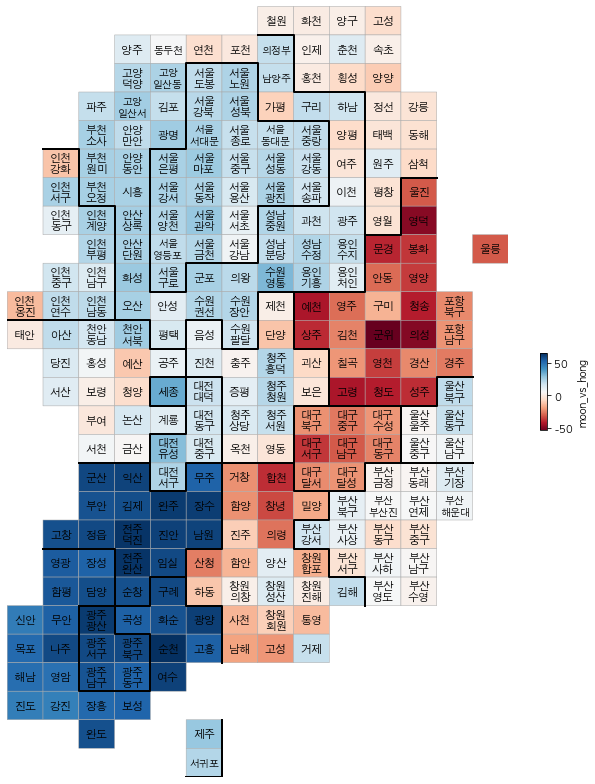

In [87]:
drawKorea('moon_vs_hong', final_elect_data, 'RdBu')

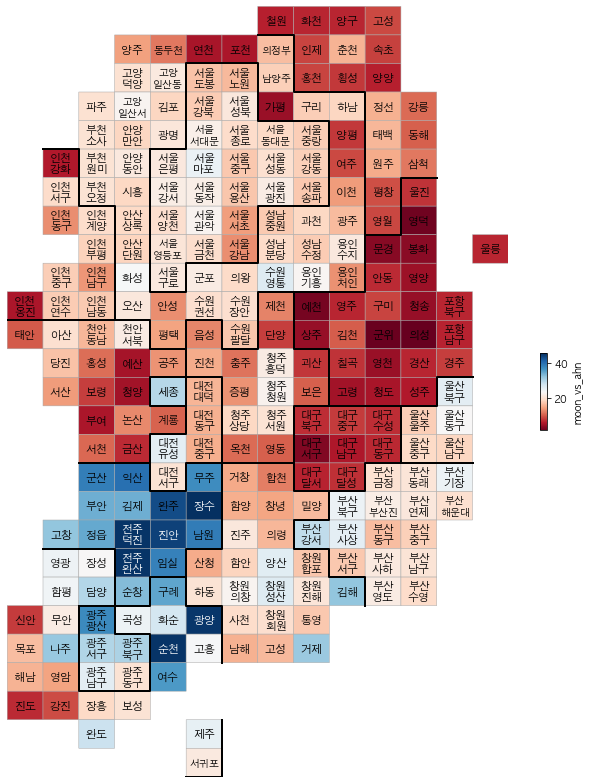

In [89]:
drawKorea('moon_vs_ahn', final_elect_data, 'RdBu')

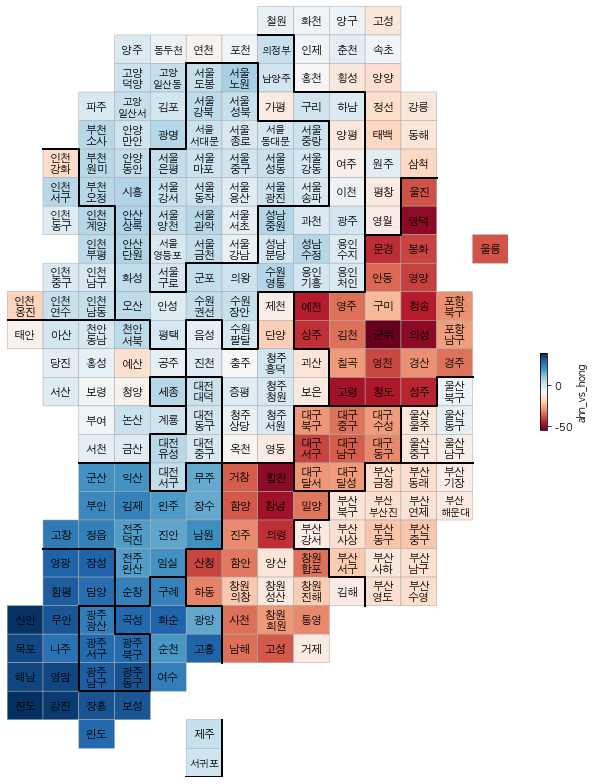

In [90]:
drawKorea('ahn_vs_hong', final_elect_data, 'RdBu')

In [92]:
import folium
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [93]:
pop_folium = final_elect_data.set_index('ID')

del pop_folium['광역시도']
del pop_folium['시군']

pop_folium.head()

,pop,moon,hong,ahn,rate_moon,rate_hong,rate_ahn,y,x,moon_vs_hong,moon_vs_ahn,ahn_vs_hong
ID,,,,,,,,,,,,
서울 종로,102566.0,42512.0,22325,22313,41.448433,21.766472,21.754773,4,6,19.681961,19.693661,-0.011700
서울 중구,82852.0,34062.0,17901,19372,41.111862,21.605996,23.381451,5,6,19.505866,17.730411,1.775455
서울 용산,148157.0,58081.0,35230,32109,39.202333,23.778829,21.672280,6,6,15.423503,17.530053,-2.106549
서울 성동,203175.0,86686.0,40566,45674,42.665682,19.966039,22.480128,5,7,22.699643,20.185554,2.514089
서울 광진,240030.0,105512.0,46368,52824,43.957839,19.317585,22.007249,6,7,24.640253,21.950590,2.689664


In [94]:
geo_path = './skorea_municipalities_geo_simple.json'
geo_data = json.load(open(geo_path, encoding='utf-8'))

map = folium.Map(location=[36.2002, 127.054], zoom_start=6)
map.choropleth(geo_data=geo_data,
              data=pop_folium['moon_vs_hong'],
              columns=[pop_folium.index, pop_folium['moon_vs_hong']],
              fill_color='PuBu',
              key_on='feature.id')

map